## Računalni vid: 1. laboratorijska vježba

In [1]:
import matplotlib.pyplot as plt
import scipy.misc as misc
import numpy as np

### Zadatak 1: Interpoliranje

In [2]:
def affine_nn(is_, A, b, h_d, w_d):
    num_colors = 1 if len(is_.shape) == 2 else 3
    new_img = np.zeros(shape=(w_d, h_d, num_colors))
    A_inv = np.linalg.inv(A)
    
    for i in range(w_d):
        for j in range(h_d):
            px = np.array([i, j])
            src = A_inv @ (px - b)
            src_nn = np.floor(src + 0.5).astype(int)
            if 0 < src_nn[0] < is_.shape[0] and 0 < src_nn[1] < is_.shape[1]: 
                new_img[i, j] = is_[src_nn[0], src_nn[1]]
    
    return new_img

def affine_bilin(is_, A, b, h_d, w_d):
    num_colors = 1 if len(is_.shape) == 2 else 3
    new_img = np.zeros(shape=(w_d, h_d, num_colors))
    A_inv = np.linalg.inv(A)
    
    for i in range(w_d):
        for j in range(h_d):
            px = np.array([i, j])
            src = A_inv @ (px - b)
            if 1 < src[0] < is_.shape[0]-1 and 1 < src[1] < is_.shape[1]-1:
                x, y = src[0], src[1]
                x1, y1 = np.floor(src[0]).astype(int), np.floor(src[1]).astype(int)
                x2, y2 = x1 + 1, y1 + 1
                new_img[i, j] = (y2-y) * (x2-x) * is_[x1, y1] + (y2-y) * (x-x1) * is_[x2, y1] + \
                                (y-y1) * (x2-x) * is_[x1, y2] + (y-y1) * (x-x1) * is_[x2, y2]
    return new_img

def define_A_and_b(is_, h_d, w_d):
    is_coords = is_.shape if len(is_.shape) == 2 else is_.shape[:-1]
    A = .25 * np.eye(2) + np.random.normal([2, 2])
    qd, qs = np.array([h_d//2, w_d//2]), np.array(is_coords)//2
    b = qd - A @ qs
    return A, b

Standard devijacija: 5.476181065160051


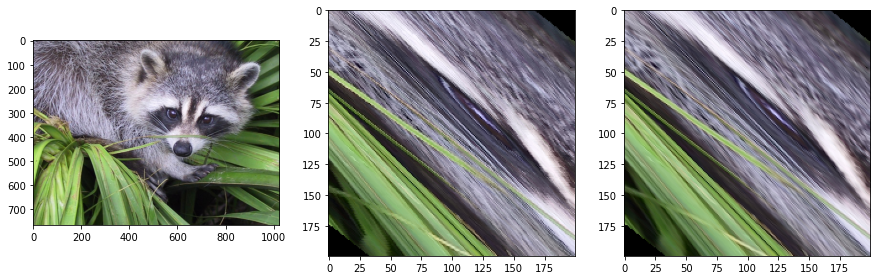

In [3]:
is_ = misc.face()
is_ = np.asarray(is_)
h_d, w_d = 200, 200

A, b = define_A_and_b(is_, h_d, w_d)

id1 = affine_nn(is_, A, b, h_d, w_d)
id2 = affine_bilin(is_, A, b, h_d, w_d)
print(f'Standard devijacija: {np.std(id1 - id2)}')

fig = plt.figure(figsize=(15, 15))
if len(is_.shape) == 2: 
    plt.gray()
for i,im in enumerate([is_, id1, id2]):
    fig.add_subplot(1,3, i+1)
    plt.imshow(im.astype(int))
plt.show()

### Zadatak 2: Procjena afine transformacije iz korespondencija

In [4]:
def recover_affine_diamond(h_s, w_s, h_d, w_d):
    x1, y1, x1_, y1_ = w_s/2, 0., w_d, 0.
    x2, y2, x2_, y2_ = 0., h_s/2, 0., 0.
    x3, y3, x3_, y3_ = w_s/2, h_s, 0, h_d
    
    A = np.array([
        [x1, y1, 0., 0., 1., 0.],
        [0., 0., x1, y1, 0., 1.],
        [x2, y2, 0., 0., 1., 0.],
        [0., 0., x2, y2, 0., 1.],
        [x3, y3, 0., 0., 1., 0.],
        [0., 0., x3, y3, 0., 1.]
    ])
    b = np.array([x1_, y1_, x2_, y2_, x3_, y3_])    
    
    solution = np.linalg.solve(A, b)
    A = solution[:-2].reshape(2, 2)
    b = solution[-2:].reshape(-1)
    return A, b

Standard devijacija: 5.720659779959638


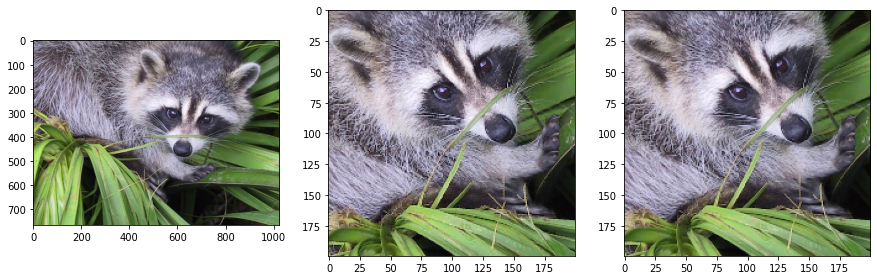

In [5]:
is_ = misc.face()
is_ = np.asarray(is_)
h_d, w_d = 200, 200
w_s, h_s = is_.shape[:2]

A, b = recover_affine_diamond(h_s, w_s, h_d, w_d)

id1 = affine_nn(is_, A, b, h_d, w_d)
id2 = affine_bilin(is_, A, b, h_d, w_d)
print(f'Standard devijacija: {np.std(id1 - id2)}')

fig = plt.figure(figsize=(15, 15))
if len(is_.shape) == 2: 
    plt.gray()
for i,im in enumerate([is_, id1, id2]):
    fig.add_subplot(1,3, i+1)
    plt.imshow(im.astype(int))
plt.show()

### Zadatak 3: Procjena projekcijske transformacije iz korespondencija

In [6]:
def recover_projective(q_s, q_d):
    x1, x2, x3, x4 = q_s[:, 0]
    y1, y2, y3, y4 = q_s[:, 1]
    x1_, x2_, x3_, x4_ = q_d[:, 0]
    y1_, y2_, y3_, y4_ = q_d[:, 1]
    M = np.array([
        [-x1, -y1,   0,   0, -1,  0, x1_, x1*x1_, y1*x1_],
        [  0,   0, -x1, -y1,  0, -1, y1_, x1*y1_, y1*y1_],
        [-x2, -y2,   0,   0, -1,  0, x2_, x2*x2_, y2*x2_],
        [  0,   0, -x2, -y2,  0, -1, y2_, x2*y2_, y2*y2_],
        [-x3, -y3,   0,   0, -1,  0, x3_, x3*x3_, y3*x3_],
        [  0,   0, -x3, -y3,  0, -1, y3_, x3*y3_, y3*y3_],
        [-x4, -y4,   0,   0, -1,  0, x4_, x4*x4_, y4*x4_],
        [  0,   0, -x4, -y4,  0, -1, y4_, x4*y4_, y4*y4_],
    ])
    
    #eig_v, eig_vec = np.linalg.eig(M.T @ M)
    #return eig_vec[:, -1]
    
    u, s, vT = np.linalg.svd(M)
    return vT[-1, :]
    
def find_q_d(A, b, w0, w, q_s):
    q_d = []
    for q_si in q_s:
        q_di = (A @ q_si + b)/(w.T @ q_si + w0)
        q_d.append(q_di)
    q_d = np.array(q_d)
    return q_d

In [7]:
q_s = np.array([
    [0, 0],
    [30, 25],
    [10, 20],
    [10, 5]
])
A, b = recover_affine_diamond(h_s, w_s, h_d, w_d)
w0, w = np.random.normal(), np.random.randn(2, 1)
q_d = find_q_d(A, b, w0, w, q_s)

to_reconstruct = np.concatenate((A, b, w0, w), axis=None)

decimals = 4
print(f'The vector to reconstruct: {np.round(to_reconstruct, decimals=decimals).tolist()}')

H = recover_projective(q_s, q_d)
lambda_ = A[0][0]/H[0]
H = lambda_ * H
print(f' The reconstructed vector: {np.round(H, decimals=decimals).tolist()}')

The vector to reconstruct: [0.2604, -0.1953, 0.2604, 0.1953, 100.0, -100.0, -1.188, 1.0072, 0.9266]
 The reconstructed vector: [0.2604, -0.1953, 0.2604, 0.1953, 100.0, -100.0, -1.188, 1.0072, 0.9266]
